In [ ]:
### we probably don't need this cell

def tvb_make_sim_file(pse_name, subj_list, param1_name, param1_min, param1_max, param1_num, param2_name, param2_min, param2_max, param2_num):
    import numpy as np
    f = open('sim_info_' + pse_name + '.txt', 'write')
    f.write('SUBJECTS: \t' + subj_list + '\n')
    f.write('Parameter 1: \t' + param1_name + '\n')
    f.write('Parameter 2: \t' + param2_name + '\n')
    f.close()
    p1 = np.linspace(param1_min, param1_max, param1_num)
    p2 = np.linspace(param2_min, param2_max, param2_num)
    np.savetxt('sim_params_' + pse_name + '_param1.txt', p1, fmt='%.4f', delimiter=' ', newline='\n')
    np.savetxt('sim_params_' + pse_name + '_param2.txt', p2, fmt='%.4f', delimiter=' ', newline='\n')
    

In [1]:
# https://groups.google.com/forum/#!topic/tvb-users/ODsL9bkGLHQ

import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np
from nipype import Node, Function, Workflow
#from tvb.simulator.lab import *

cwd = os.getcwd()

# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html

# done
def make_pse(parameter_ranges): # done, need to wrap
    import numpy as np
    pse_list = dict(parameter_ranges)
    return pse_list

def make_model(model_name, parameters):# done
    import warnings, pickle, os
    warnings.filterwarnings('ignore')
    from tvb.simulator.lab import models
    import numpy as np
    mod = getattr(models, model_name)
    model_class = mod(**dict(parameters))
    pickle.dump(model_class, open("model_class.p", "wb"))
    model_class = os.path.abspath("model_class.p")
    return model_class

def load_connectivity_mat(in_file, normalize=False):
    import scipy.io, pickle, os
    datamat = scipy.io.loadmat(in_file)
    sc_weights = datamat['sc_weights']
    if normalize:
        sc_weights = sc_weights / sc_weights.max()
    tract_lengths = datamat['tract_lengths']
    pickle.dump(sc_weights, open("sc_weights.p", "wb"))
    pickle.dump(tract_lengths, open("tract_lengths.p", "wb"))
    sc_weights = os.path.abspath("sc_weights.p")
    tract_lengths = os.path.abspath("tract_lengths.p")
    return sc_weights, tract_lengths
    
def make_connectivity(weights, lengths):
    import warnings, pickle, os
    warnings.filterwarnings('ignore')
    weights = pickle.load(open(weights, "rb"))
    lengths = pickle.load(open(lengths, "rb"))
    from tvb.simulator.lab import connectivity
    conn_class = connectivity.Connectivity(weights=weights, tract_lengths=lengths)
    pickle.dump(conn_class, open("conn_class.p", "wb"))
    conn_class = os.path.abspath("conn_class.p")
    return conn_class

def make_integrator(integrator_name, base_dt, noise_type, noise_val):
    import sys, numpy, warnings, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand 
    from tvb.simulator.lab import integrators #, noise
    temp_integrator = getattr(integrators,integrator_name)
    #temp_noise = getattr(noise, noise_type)
    #noise = temp_noise(nsig = np.array(noise_val))
    # integrator_class = temp_integrator(dt = base_dt, noise = noise)
    integrator_class = temp_integrator(dt = base_dt)
    pickle.dump(integrator_class, open("integrator_class.p", "wb"))
    integrator_class = os.path.abspath("integrator_class.p")
    return integrator_class

def make_monitors(monitor_type, parameters):
    import warnings, sys, numpy, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    from tvb.simulator.lab import monitors
    monitor_tmp = getattr(monitors,monitor_type)
    monitor_class = monitor_tmp(**dict(parameters))
    pickle.dump(monitor_class, open("monitor_class.p", "wb"))
    monitor_class = os.path.abspath("monitor_class.p")
    return monitor_class

def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=2.0, simulation_length=1000.0):
    import warnings, sys, numpy, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    
    model_input = pickle.load(open(model_input, "rb"))
    conn_input = pickle.load(open(conn_input, "rb"))
    integrator_input = pickle.load(open(integrator_input, "rb"))
    monitor_input = pickle.load(open(monitor_input, "rb"))

    from tvb.simulator.lab import *
    wm_coupling = coupling.Linear(a = global_coupling)
    
    # testing things # fix this
    model_input = models.Generic2dOscillator()
    integrator_input = integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=numpy.array([0.001])))
    monitor_input = (monitors.Bold(period=2000.0), monitors.TemporalAverage(period=10.0), monitors.ProgressLogger(period=10000.0))
    
    
    sim = simulator.Simulator(model = model_input, connectivity = conn_input, coupling = wm_coupling,
                             integrator = integrator_input, monitors = monitor_input,
                             simulation_length = 1000.0, conduction_speed = 3.0)
    
    sim.configure()
    (time, data), (tavg_time, tavg_data), _ = sim.run()
    # numpy.save(out_file, data)
    scipy.io.savemat('sim_data.mat',{'data': data})
    abs_out_file = os.path.abspath("sim_data.mat") # fix this
    return abs_out_file

##### NIPYPE PORTION
# https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html

pse_params = Node(
    Function(
        input_names=['parameter_ranges'],
        output_names=['model_class'],
        function=make_pse
    ),
    name='create_pse'
)

model = Node(
    Function(
        input_names=['model_name', 'parameters'],
        output_names=['model_class'],
        function=make_model
    ),
    name='create_model'
)
 
sc_loader = Node(
    Function(
        input_names=['in_file', 'normalize'],
        output_names=['sc_weights', 'tract_lengths'],
        function=load_connectivity_mat
    ),
    name='load_sc_mat'
)

sc = Node(
    Function(
        input_names=['weights', 'lengths'],
        output_names=['conn_class'],
        function=make_connectivity
    ),
    name='create_sc'
)

integrator = Node(
    Function(
        input_names=['integrator_name','base_dt','noise_type','noise_val'],
        output_names=['integrator_class'],
        function=make_integrator
    ),
    name='create_integrator'
)

monitors = Node(
    Function(
        input_names=['monitor_type','parameters'],
        output_names=['monitor_class'],
        function=make_monitors
    ),
    name='create_monitors'
)

simulate = Node(
    Function(
        input_names=['out_file', 'model_input', 'conn_input', 'integrator_input', 'monitor_input',
                     'global_coupling', 'conduction_speed', 'simulation_length'],
        output_names=['abs_out_file'],
        function=run_simulation
    ),
    name='create_simulation'
)



In [4]:
# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html
workflow = Workflow(name='tvb_demo', base_dir=os.getcwd())
workflow.connect([
    (model, simulate, [("model_class", "model_input")]),
    (sc_loader, sc, [("sc_weights", "weights"), ("tract_lengths", "lengths")]),
    (sc, simulate, [("conn_class", "conn_input")]),
    (integrator, simulate, [("integrator_class", "integrator_input")]),
    (monitors, simulate, [("monitor_class", "monitor_input")])
])


# NOW DEFINE YOUR INPUTS
# https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html
model.inputs.model_name = 'Generic2dOscillator'
model.inputs.parameters = [('a',1), ('b',1)]
# https://miykael.github.io/nipype_tutorial/notebooks/basic_iteration.html
# workflow.model.iterables = ('parameters', [4, 8, 16])
sc_loader.inputs.in_file = cwd + '/input/sub-01_connectivity.mat'
sc_loader.inputs.normalize = False 
integrator.inputs.integrator_name = 'HeunStochastic'
integrator.inputs.base_dt = 0.1
integrator.inputs.noise_type = 'Additive'
integrator.inputs.noise_val = 0.0001
#workflow.integrator.iterables = ('noise', [1, 2, 3, 4])
monitors.inputs.monitor_type = 'TemporalAverage'
monitors.inputs.parameters = [('period',10)]
simulate.inputs.out_file = cwd + '/tvb_test1.mat'
simulate.inputs.global_coupling = 0.1
simulate.inputs.conduction_speed = 2.0
simulate.inputs.simulation_length = 10000.0

# ^ move constants to top node; have initial node with subject list 
# make datasink at the end to clean things up 
#def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=2.0, simulation_length=1000.0):


180809-11:27:44,423 nipype.workflow INFO:
	 Generated workflow graph: /mnt/c/Users/easso/docs/neurohackademy/tvb_nipype/graph_orig.png (graph2use=orig, simple_form=True).


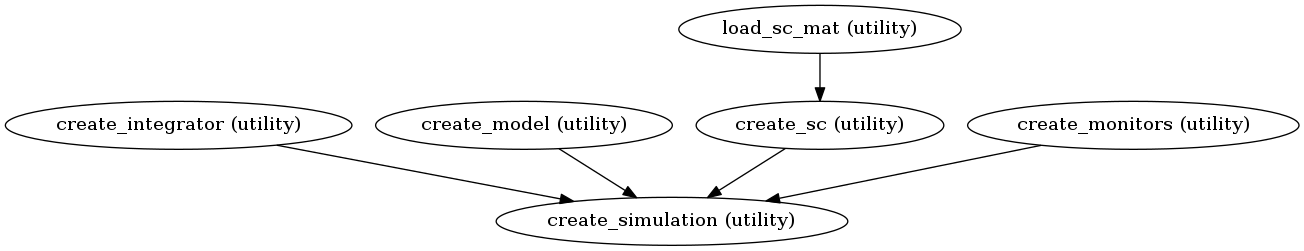

In [5]:
# Write graph of type orig
workflow.write_graph(graph2use='orig', dotfilename='./graph_orig.dot')

# Visualize graph
from IPython.display import Image
Image(filename="graph_orig.png")

In [6]:
#workflow.run('MultiProc', plugin_args={'n_procs': 10})
# import sys, pickle, numpy
# sys.modules['mtrand'] = numpy.random.mtrand
workflow.run()

180809-11:27:47,771 nipype.workflow INFO:
	 Workflow tvb_demo settings: ['check', 'execution', 'logging', 'monitoring']
180809-11:27:47,875 nipype.workflow INFO:
	 Running serially.
180809-11:27:47,886 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_monitors" in "/mnt/c/Users/easso/docs/neurohackademy/tvb_nipype/tvb_demo/create_monitors".
180809-11:27:47,915 nipype.workflow INFO:
	 [Node] Cached "tvb_demo.create_monitors" - collecting precomputed outputs
180809-11:27:47,922 nipype.workflow INFO:
	 [Node] "tvb_demo.create_monitors" found cached.
180809-11:27:47,930 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.load_sc_mat" in "/mnt/c/Users/easso/docs/neurohackademy/tvb_nipype/tvb_demo/load_sc_mat".
180809-11:27:47,953 nipype.workflow INFO:
	 [Node] Cached "tvb_demo.load_sc_mat" - collecting precomputed outputs
180809-11:27:47,963 nipype.workflow INFO:
	 [Node] "tvb_demo.load_sc_mat" found cached.
180809-11:27:47,978 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.cr

In [ ]:
!nipypecli crash crash-20180808-232710-amandae-create_sc-c2a7d07a-34e3-4198-b5c3-079609bf1f18.pklz


In [ ]:
sim